# LM-MLE fitting in Python

Need to implement our own version of LM-MLE fitting in python, because you cannot simply change the $\chi^2$ function, you also have to change the gradients.

Here's a C implementation:
http://users.ics.forth.gr/~lourakis/levmar/

Basic plan is to replace the `leastsq` function, monkey patching that in instead

`_wrap_func` is here: https://github.com/scipy/scipy/blob/master/scipy/optimize/minpack.py

`_wrap_func` returns $\chi_i$ where, for Gaussian noise, $\chi_i = \frac{f_i - x_i}{\sigma_i}$ and $\chi^2 = \sum \chi_i^2$

The call function in `curve_fit` looks like this:
```python
    ...
    # Determine type of sigma
    if sigma is not None:
        sigma = np.asarray(sigma)

        # if 1-d, sigma are errors, define transform = 1/sigma
        if sigma.shape == (ydata.size, ):
            transform = 1.0 / sigma
        # if 2-d, sigma is the covariance matrix,
        # define transform = L such that L L^T = C
        elif sigma.shape == (ydata.size, ydata.size):
            try:
                # scipy.linalg.cholesky requires lower=True to return L L^T = A
                transform = cholesky(sigma, lower=True)
            except LinAlgError:
                raise ValueError("`sigma` must be positive definite.")
        else:
            raise ValueError("`sigma` has incorrect shape.")
    else:
        transform = None

    func = _wrap_func(f, xdata, ydata, transform)
    if callable(jac):
        jac = _wrap_jac(jac, xdata, transform)
    elif jac is None and method != 'lm':
        jac = '2-point'

    if method == 'lm':
        # Remove full_output from kwargs, otherwise we're passing it in twice.
        return_full = kwargs.pop('full_output', False)
        res = leastsq(func, p0, Dfun=jac, full_output=1, **kwargs)
        popt, pcov, infodict, errmsg, ier = res
        cost = np.sum(infodict['fvec'] ** 2)
        if ier not in [1, 2, 3, 4]:
            raise RuntimeError("Optimal parameters not found: " + errmsg)
    ...
```

# Simple LS LM

Here I attempt to implement a simple, fully pythonic, version of LM. To make life ridiculously easy I'll start with modeling an exponential equation $y = A e^{-k t} + o$.

In [1]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
%load_ext line_profiler

My test function will be two gaussians

$$
y = A_0 e^{-\frac{(x-x_0)^2}{\sigma_0^2}} + A_1 e^{-\frac{(x-x_1)^2}{\sigma_1^2}} + O
$$

In [2]:
def test_func(xdata, a0, x0, sigma0, a1, x1, sigma1, o):
    """An exponential decay"""
    return a0 * np.exp(-(xdata-x0)**2 / sigma0**2) + a1 * np.exp(-(xdata-x1)**2 / sigma1**2) + o

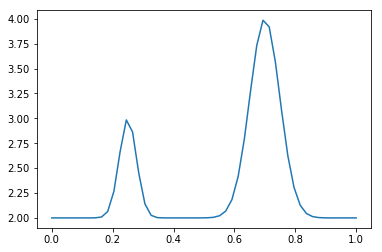

In [3]:
x = np.linspace(0,1)
preal = np.array([1, 0.25, .04, 2, 0.7, 0.07, 2])
y = test_func(x, *preal)
plt.plot(x, y)

In [4]:
def test_func_jac(xdata, a0, x0, sigma0, a1, x1, sigma1, o):
    """An exponential decay"""
    dyda0 = np.exp(-(xdata-x0)**2 / sigma0**2)
    dydx0 = 2 * a0 * (xdata-x0) * dyda0 / sigma0**2
    dydsigma0 = dydx0 * (xdata-x0) / sigma0
    
    dyda1 = np.exp(-(xdata-x1)**2 / sigma1**2)
    dydx1 = 2 * a1 * (xdata-x1) * dyda1 / sigma1**2
    dydsigma1 = dydx1 * (xdata-x1) / sigma1
    
    dydo = np.ones_like(dyda0)
    
    to_return = np.concatenate((dyda0, dydx0, dydsigma0, dyda1, dydx1, dydsigma1, dydo))
    to_return.shape = (7, -1)
#     to_return = np.vstack((dyda0, dydx0, dydsigma0, dyda1, dydx1, dydsigma1, dydo))
    return to_return.T

## Test fit with `scipy.optimize.curve_fit`

In [5]:
from scipy.optimize import curve_fit

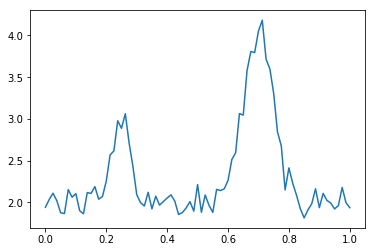

In [6]:
x = np.linspace(0,1, 81)
y = test_func(x, *preal) + 0.1*np.random.randn(len(x))
plt.plot(x, y)

In [7]:
preal

array([ 1.  ,  0.25,  0.04,  2.  ,  0.7 ,  0.07,  2.  ])

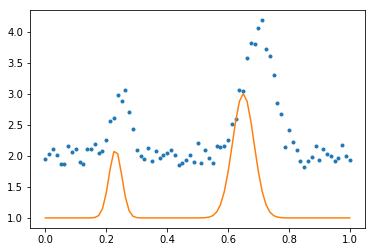

In [8]:
pguess = np.array([ 1.1  ,  0.23,  0.03,  2.  ,  0.65 ,  0.05 ,  1.  ])
y_fit = test_func(x, *pguess)
plt.plot(x, y, ".")
plt.plot(x, y_fit)

In [9]:
%%time
popt_sp, pcov, infodict, errmsg, ier = curve_fit(
    test_func, x, y, p0=pguess, full_output=True,
    jac=test_func_jac)

Wall time: 1.97 ms


In [10]:
popt_sp

array([ 1.02680848,  0.24900876,  0.04033335,  2.04787024,  0.7001997 ,
        0.06962797,  1.99959199])

0.88478569050383293

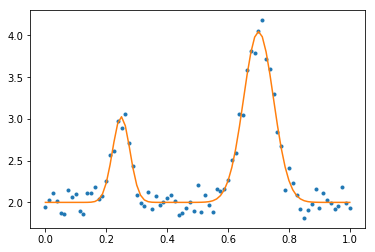

In [11]:
y_fit = test_func(x, *popt_sp)
plt.plot(x, y, ".")
plt.plot(x, y_fit)
((y-y_fit)**2).sum()

In [12]:
def chi2(y, ydata):
    return 0.5 * ((y - ydata)**2).sum()

def lm_update(xdata, f, p, jac):
    """should use partials inside lm_ls"""
    # calculate the jacobian
    # j shape (ndata, nparams)
    j = jac(xdata, *p)
    # calculate the linear term of Hessian
    # a shape (nparams, nparams)
    a = j.T @ j
    # calculate the gradient
    # g shape (nparams,)
    g = j.T @ f
    return a, g

def lm_ls(func, xdata, ydata, p0, jac, ftol=1.49012e-8, xtol=1.49012e-8, gtol=0.0,
         maxfev=None, factor=100):
    """A test implementation of levenburg-marquet
    
    ftol : float, optional
        Relative error desired in the sum of squares.
    xtol : float, optional
        Relative error desired in the approximate solution.
    gtol : float, optional
        Orthogonality desired between the function vector and the
        columns of the Jacobian.
    """
    if maxfev is None:
        maxfev = 100 * (len(p0) + 1)

#     gtest = mubda g : npla.norm(g, np.inf) <= gtol
    def gtest(g):
        return np.abs(g).max() <= gtol
    def xtest(dp, p):
        norm_dp = la.norm(dp)
        return norm_dp <= xtol * (norm_dp + xtol)
    # need residuals
    y = func(xdata, *p0)
    a, g = lm_update(xdata, y - ydata, p0, jac)
    chisq_old = chi2(y, ydata)
    mu = factor * np.diagonal(a).max()
#     v = 10
    p = p0
    for ev in range(maxfev):
        if gtest(g):
            break
        # calculate proposed step
        aug_a = a + np.diag(np.ones_like(g) * mu)
        # dp = la.lstsq(aug_a, -g)[0]
        dp = -la.inv(aug_a) @ g
        if xtest(dp, p):
            break
        # make test move, I think I should be saving previous
        # position so that I can "undo" if this is bad
        p = p0 + dp
        y = func(xdata, *p)
        chisq_new = chi2(y, ydata)
        # see if we reduced chisq, note we should do more here
#         predicted_gain = 0.5 * dp.T @ (mu * dp - g)
        rho = (chisq_old - chisq_new) # / predicted_gain
        if rho > 0:
            if rho <= ftol * chisq_old:
                break
            # update params, chisq and a and g
            p0 = p
            chisq_old = chisq_new
            a, g = lm_update(xdata, y - ydata, p0, jac)
            mu = mu / factor
        else:
            mu *= factor
    return p

In [13]:
ta, tb = np.random.randn(7, 7), np.random.randn(700)
assert np.array_equal(np.dot(tb, tb), tb.T @ tb)
%timeit np.dot(tb, tb)
%timeit tb.T @ tb

761 ns ± 6.51 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
852 ns ± 6.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [14]:
ta, tb = np.random.randn(7, 7), np.random.randn(7)
%timeit la.lstsq(ta, tb)
%timeit la.pinv(ta) @ tb
%timeit la.inv(ta) @ tb
%timeit la.lstsq(ta, tb, 1e-6)
%timeit la.lstsq(ta, tb, 1e-8)
%timeit la.lstsq(ta, tb, 1e-10)
%timeit la.lstsq(ta, tb, 1e-15)
ta = ta.astype(np.float32)
tb = tb.astype(np.float32)
%timeit la.lstsq(ta, tb)

61.8 µs ± 590 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
60.2 µs ± 661 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
15 µs ± 42.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
63.2 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.9 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.2 µs ± 588 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
61.4 µs ± 551 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
63.4 µs ± 490 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Wall time: 6 ms


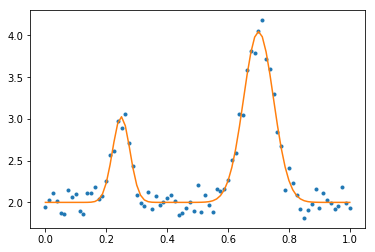

In [15]:
%time popt = lm_ls(test_func, x, y, pguess, test_func_jac)
y_fit = test_func(x, *popt)
plt.plot(x, y, ".")
plt.plot(x, y_fit)

In [16]:
np.allclose(popt, popt_sp)

True

In [17]:
curve_fit(test_func, x, y, p0=pguess, full_output=True, jac=test_func_jac)

(array([ 1.02680848,  0.24900876,  0.04033335,  2.04787024,  0.7001997 ,
         0.06962797,  1.99959199]),
 array([[  4.55978703e-03,  -6.91172310e-17,  -1.06334926e-04,
           1.24743577e-04,  -1.78130237e-14,   8.48260776e-06,
          -1.76414055e-04],
        [ -6.91172310e-17,   4.56157775e-06,  -5.43314763e-18,
           3.85098310e-16,   3.32655007e-18,  -3.62886989e-17,
           9.78006393e-17],
        [ -1.06334926e-04,  -5.43314763e-18,   9.89297098e-06,
           9.79946618e-06,  -1.36314658e-15,   6.66367200e-07,
          -1.38585377e-05],
        [  1.24743577e-04,   3.85098310e-16,   9.79946618e-06,
           2.69374527e-03,  -1.75903493e-14,  -4.97484050e-05,
          -1.76414058e-04],
        [ -1.78130237e-14,   3.32655007e-18,  -1.36314658e-15,
          -1.75903493e-14,   1.97986491e-06,  -1.19614916e-15,
           2.48765011e-14],
        [  8.48260776e-06,  -3.62886989e-17,   6.66367200e-07,
          -4.97484050e-05,  -1.19614916e-15,   4.53655018e

In [18]:
%timeit curve_fit(test_func, x, y, p0=pguess, full_output=True, jac=test_func_jac)
%timeit lm_ls(test_func, x, y, pguess, test_func_jac)

902 µs ± 5.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.58 ms ± 9.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%lprun -f lm_ls lm_ls(test_func, x, y, pguess, test_func_jac)

# Matching the calling

I want to match the call signature of [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

```python
popt, pcov, infodict, errmsg, ier = curve_fit(
    model_ravel, (xx, yy), data.ravel(), p0=guess_params,
    bounds=bounds, full_output=True, jac=self.model_jac)
```

In [20]:
def chi2_ls(f):
    """$\chi^2_ls$"""
    return 0.5 * (f**2).sum(0)

def update_ls(x0, f, Dfun):
    """should use partials inside lm_ls"""
    # calculate the jacobian
    # j shape (ndata, nparams)
    j = Dfun(x0)
    # calculate the linear term of Hessian
    # a shape (nparams, nparams)
    a = j.T @ j
    # calculate the gradient
    # g shape (nparams,)
    g = j.T @ f
    return j, a, g

def chi2_mle(f):
    """$\chi^2_ls$"""
    f, y = f
    if f.min() <= 0:
        # this is not allowed so make chi2
        # large to avoid
        return np.inf
    part1 = 2 * (f - y).sum()
    part2 = - 2 * (y * np.log(f / y))[y > 0].sum()
    return part1 + part2

def update_mle(x0, f, Dfun):
    """should use partials inside lm_ls"""
    # calculate the jacobian
    # j shape (ndata, nparams)
    f, y = f
    j = Dfun(x0)
    # calculate the linear term of Hessian
    # a shape (nparams, nparams)
    a = j.T @ j
    # calculate the gradient
    # g shape (nparams,)
    g = j.T @ f
    return j, a, g

def _wrap_func_mle(func, xdata, ydata, transform):
    """Returns f and xdata"""
    if transform is None:
        def func_wrapped(params):
            return func(xdata, *params), ydata
    elif transform.ndim == 1:
        raise NotImplementedError
    else:
        # Chisq = (y - yd)^T C^{-1} (y-yd)
        # transform = L such that C = L L^T
        # C^{-1} = L^{-T} L^{-1}
        # Chisq = (y - yd)^T L^{-T} L^{-1} (y-yd)
        # Define (y-yd)' = L^{-1} (y-yd)
        # by solving
        # L (y-yd)' = (y-yd)
        # and minimize (y-yd)'^T (y-yd)'
        raise NotImplementedError
    return func_wrapped


def _wrap_jac_mle(jac, xdata, transform):
    if transform is None:
        def jac_wrapped(params):
            return jac(xdata, *params)
    elif transform.ndim == 1:
        raise NotImplementedError
    else:
        raise NotImplementedError
    return jac_wrapped

def leastsq_ls(func, x0, args=(), Dfun=None, full_output=False,
                col_deriv=True, ftol=1.49012e-8, xtol=1.49012e-8,
                gtol=0.0, maxfev=None, epsfcn=None, factor=100, diag=None):
    """A more thorough implementation of levenburg-marquet
    for gaussian Noise
    ::
        x = arg min(sum(func(y)**2,axis=0))
                 y
    Parameters
    ----------
    func : callable
        should take at least one (possibly length N vector) argument and
        returns M floating point numbers. It must not return NaNs or
        fitting might fail.
    x0 : ndarray
        The starting estimate for the minimization.
    args : tuple, optional
        Any extra arguments to func are placed in this tuple.
    Dfun : callable, optional
        A function or method to compute the Jacobian of func with derivatives
        across the rows. If this is None, the Jacobian will be estimated.
    full_output : bool, optional
        non-zero to return all optional outputs.
    col_deriv : bool, optional
        non-zero to specify that the Jacobian function computes derivatives
        down the columns (faster, because there is no transpose operation).
    ftol : float, optional
        Relative error desired in the sum of squares.
    xtol : float, optional
        Relative error desired in the approximate solution.
    gtol : float, optional
        Orthogonality desired between the function vector and the columns of
        the Jacobian.
    maxfev : int, optional
        The maximum number of calls to the function. If `Dfun` is provided
        then the default `maxfev` is 100*(N+1) where N is the number of elements
        in x0, otherwise the default `maxfev` is 200*(N+1).
    epsfcn : float, optional
        A variable used in determining a suitable step length for the forward-
        difference approximation of the Jacobian (for Dfun=None).
        Normally the actual step length will be sqrt(epsfcn)*x
        If epsfcn is less than the machine precision, it is assumed that the
        relative errors are of the order of the machine precision.
    factor : float, optional
        A parameter determining the initial step bound
        (``factor * || diag * x||``). Should be in interval ``(0.1, 100)``.
    diag : sequence, optional
        N positive entries that serve as a scale factors for the variables.
    """
    
    x0 = np.asarray(x0).flatten()
    n = len(x0)
    if not isinstance(args, tuple):
        args = (args,)
#     shape, dtype = _check_func('leastsq', 'func', func, x0, args, n)
#     m = shape[0]
#     if n > m:
#         raise TypeError('Improper input: N=%s must not exceed M=%s' % (n, m))
    if Dfun is None:
        raise NotImplementedError
        if epsfcn is None:
            epsfcn = np.finfo(dtype).eps
    else:
        if col_deriv:
            pass
#             _check_func('leastsq', 'Dfun', Dfun, x0, args, n, (n, m))
        else:
            raise NotImplementedError("Column derivatives required")
        if maxfev is None:
            maxfev = 100 * (n + 1)

    errors = {0: ["Improper input parameters.", TypeError],
              1: ["Both actual and predicted relative reductions "
                  "in the sum of squares\n  are at most %f" % ftol, None],
              2: ["The relative error between two consecutive "
                  "iterates is at most %f" % xtol, None],
              3: ["Both actual and predicted relative reductions in "
                  "the sum of squares\n  are at most %f and the "
                  "relative error between two consecutive "
                  "iterates is at \n  most %f" % (ftol, xtol), None],
              4: ["The cosine of the angle between func(x) and any "
                  "column of the\n  Jacobian is at most %f in "
                  "absolute value" % gtol, None],
              5: ["Number of calls to function has reached "
                  "maxfev = %d." % maxfev, ValueError],
              6: ["ftol=%f is too small, no further reduction "
                  "in the sum of squares\n  is possible.""" % ftol,
                  ValueError],
              7: ["xtol=%f is too small, no further improvement in "
                  "the approximate\n  solution is possible." % xtol,
                  ValueError],
              8: ["gtol=%f is too small, func(x) is orthogonal to the "
                  "columns of\n  the Jacobian to machine "
                  "precision." % gtol, ValueError],
              'unknown': ["Unknown error.", TypeError]}
    
    if maxfev is None:
        maxfev = 100 * (len(p0) + 1)

#     gtest = lambda g : npla.norm(g, np.inf) <= gtol
    def gtest(g):
        if gtol:
            return np.abs(g).max() <= gtol
        else:
            return False
    def xtest(dp, p):
        norm_dp = la.norm(dp)
        return norm_dp <= xtol * (norm_dp + xtol)
    
    # need residuals
    def update(x0, f):
        """should use partials inside lm_ls"""
        return update_ls(x0, f, Dfun)

    f = func(x0)
    j, a, g = update(x0, f)
    
    chisq_old = chi2_ls(f)
    
    lam = factor * np.diagonal(a).max()
    
    x = x0
    
    for ev in range(maxfev):
        if gtest(g):
            break
        # calculate proposed step
        aug_a = a + np.diag(np.ones_like(g) * lam)
        dx = -la.inv(aug_a) @ g
        if xtest(dx, x):
            break
        # make test move, I think I should be saving previous
        # position so that I can "undo" if this is bad
        x = x0 + dx
        f = func(x)
        chisq_new = chi2_ls(f)
        # see if we reduced chisq, note we should do more here
        rho = chisq_old - chisq_new
        if rho > 0:
            if rho <= ftol * chisq_old:
                break
            # update params, chisq and a and g
            x0 = x
            chisq_old = chisq_new
            j, a, g = update(x0, f)
            lam /= factor
        else:
            lam *= factor
            
    infodict = dict(fvec=f, nfev=ev)
    popt, pcov, errmsg, ier = x, None, None, 1
    if full_output:
        return popt, pcov, infodict, errmsg, ier
    else:
        return popt, pcov

In [21]:
def _wrap_func_ls(func, xdata, ydata, transform):
    if transform is None:
        def func_wrapped(params):
            return func(xdata, *params) - ydata
    elif transform.ndim == 1:
        def func_wrapped(params):
            return transform * (func(xdata, *params) - ydata)
    else:
        # Chisq = (y - yd)^T C^{-1} (y-yd)
        # transform = L such that C = L L^T
        # C^{-1} = L^{-T} L^{-1}
        # Chisq = (y - yd)^T L^{-T} L^{-1} (y-yd)
        # Define (y-yd)' = L^{-1} (y-yd)
        # by solving
        # L (y-yd)' = (y-yd)
        # and minimize (y-yd)'^T (y-yd)'
        def func_wrapped(params):
            return solve_triangular(transform, func(xdata, *params) - ydata, lower=True)
    return func_wrapped


def _wrap_jac_ls(jac, xdata, transform):
    if transform is None:
        def jac_wrapped(params):
            return jac(xdata, *params)
    elif transform.ndim == 1:
        def jac_wrapped(params):
            return transform[:, np.newaxis] * np.asarray(jac(xdata, *params))
    else:
        def jac_wrapped(params):
            return solve_triangular(transform, np.asarray(jac(xdata, *params)), lower=True)
    return jac_wrapped

def curve_fit_ls(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False,
                  check_finite=True, bounds=(-np.inf, np.inf), method=None,
                  jac=None, **kwargs):
    """
    Use non-linear least squares to fit a function, f, to data.
    Assumes ``ydata = poisson(f(xdata, *params))``
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
        The independent variable where the data is measured.
    ydata : M-length sequence
        The dependent data --- nominally f(xdata, ...)
    p0 : None, scalar, or N-length sequence, optional
        Initial guess for the parameters.  If None, then the initial
        values will all be 1 (if the number of parameters for the function
        can be determined using introspection, otherwise a ValueError
        is raised).
    sigma : None or M-length sequence or MxM array, optional
        Determines the uncertainty in `ydata`. If we define residuals as
        ``r = ydata - f(xdata, *popt)``, then the interpretation of `sigma`
        depends on its number of dimensions:
            - A 1-d `sigma` should contain values of standard deviations of
              errors in `ydata`. In this case, the optimized function is
              ``chisq = sum((r / sigma) ** 2)``.
            - A 2-d `sigma` should contain the covariance matrix of
              errors in `ydata`. In this case, the optimized function is
              ``chisq = r.T @ inv(sigma) @ r``.
              .. versionadded:: 0.19
        None (default) is equivalent of 1-d `sigma` filled with ones.
    absolute_sigma : bool, optional
        If True, `sigma` is used in an absolute sense and the estimated parameter
        covariance `pcov` reflects these absolute values.
        If False, only the relative magnitudes of the `sigma` values matter.
        The returned parameter covariance matrix `pcov` is based on scaling
        `sigma` by a constant factor. This constant is set by demanding that the
        reduced `chisq` for the optimal parameters `popt` when using the
        *scaled* `sigma` equals unity. In other words, `sigma` is scaled to
        match the sample variance of the residuals after the fit.
        Mathematically,
        ``pcov(absolute_sigma=False) = pcov(absolute_sigma=True) * chisq(popt)/(M-N)``
    check_finite : bool, optional
        If True, check that the input arrays do not contain nans of infs,
        and raise a ValueError if they do. Setting this parameter to
        False may silently produce nonsensical results if the input arrays
        do contain nans. Default is True.
    bounds : 2-tuple of array_like, optional
        Lower and upper bounds on independent variables. Defaults to no bounds.
        Each element of the tuple must be either an array with the length equal
        to the number of parameters, or a scalar (in which case the bound is
        taken to be the same for all parameters.) Use ``np.inf`` with an
        appropriate sign to disable bounds on all or some parameters.
        .. versionadded:: 0.17
    method : {'lm', 'trf', 'dogbox'}, optional
        Method to use for optimization.  See `least_squares` for more details.
        Default is 'lm' for unconstrained problems and 'trf' if `bounds` are
        provided. The method 'lm' won't work when the number of observations
        is less than the number of variables, use 'trf' or 'dogbox' in this
        case.
        .. versionadded:: 0.17
    jac : callable, string or None, optional
        Function with signature ``jac(x, ...)`` which computes the Jacobian
        matrix of the model function with respect to parameters as a dense
        array_like structure. It will be scaled according to provided `sigma`.
        If None (default), the Jacobian will be estimated numerically.
        String keywords for 'trf' and 'dogbox' methods can be used to select
        a finite difference scheme, see `least_squares`.
        .. versionadded:: 0.18
    kwargs
        Keyword arguments passed to `leastsq` for ``method='lm'`` or
        `least_squares` otherwise."""
    
    if p0 is None:
        raise NotImplementedError("You must give a guess")
    if sigma is not None:
        raise NotImplementedError("Weighting has not been implemented")
    else:
        transform = None
        
    if method is None:
        method = "lm"
        
    if jac is None:
        raise NotImplementedError("You need a Jacobian")
        
    # NaNs can not be handled
    if check_finite:
        ydata = np.asarray_chkfinite(ydata)
    else:
        ydata = np.asarray(ydata)

    if isinstance(xdata, (list, tuple, np.ndarray)):
        # `xdata` is passed straight to the user-defined `f`, so allow
        # non-array_like `xdata`.
        if check_finite:
            xdata = np.asarray_chkfinite(xdata)
        else:
            xdata = np.asarray(xdata)
            
    func = _wrap_func_ls(f, xdata, ydata, transform)
    if callable(jac):
        jac = _wrap_jac_ls(jac, xdata, transform)
    elif jac is None and method != 'lm':
        jac = '2-point'

    if method == 'lm':
        # Remove full_output from kwargs, otherwise we're passing it in twice.
        return_full = kwargs.pop('full_output', False)
        res = leastsq_ls(func, p0, Dfun=jac, full_output=1, **kwargs)
        popt, pcov, infodict, errmsg, ier = res
        cost = np.sum(infodict['fvec'] ** 2)
        if ier not in [1, 2, 3, 4]:
            raise RuntimeError("Optimal parameters not found: " + errmsg)
    else:
        raise NotImplementedError("The only available method is 'lm'")
        
    if return_full:
        return popt, pcov, infodict, errmsg, ier
    else:
        return popt, pcov

In [22]:
%%time
popt_ls, pcov, infodict, errmsg, ier = curve_fit_ls(
    test_func, x, y, p0=pguess, full_output=True,
    jac=test_func_jac)

Wall time: 1.96 ms


In [23]:
infodict

{'fvec': array([ 0.0588594 , -0.03443522, -0.11011548, -0.01940867,  0.12395848,
         0.13424116, -0.15294944, -0.06201268, -0.10506454,  0.09979297,
         0.13662627, -0.11688677, -0.10485376, -0.17888344, -0.00267116,
         0.02949788, -0.0212491 , -0.11585927,  0.10355531, -0.0316509 ,
         0.13843233, -0.14473409, -0.03331956, -0.01775987,  0.11428154,
         0.08955884,  0.07305967, -0.11207422,  0.08003372, -0.07417042,
         0.03347247, -0.00971059, -0.05268382, -0.08975216, -0.01576744,
         0.14530514,  0.12197961,  0.06596203, -0.00896741,  0.10515438,
        -0.21323916,  0.11956562, -0.08529052,  0.04394817,  0.1394458 ,
        -0.11484956, -0.06071861, -0.01291215, -0.00462925, -0.09416889,
         0.04241044, -0.15409814,  0.17186353, -0.05398968, -0.01280037,
         0.18619937, -0.00637503, -0.19785719,  0.08863435, -0.06240142,
        -0.07678917,  0.0764092 , -0.03069337,  0.27578281, -0.15101363,
        -0.07647177, -0.00349006,  0.117980

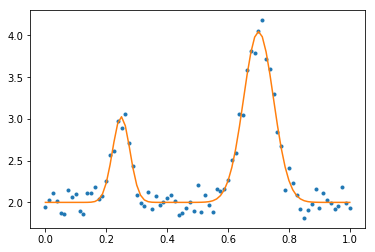

In [24]:
y_fit = test_func(x, *popt_ls)
plt.plot(x, y, ".")
plt.plot(x, y_fit)

In [25]:
np.allclose(popt_ls, popt_sp)

True

In [26]:
%%timeit
popt_ls, pcov, infodict, errmsg, ier = curve_fit_ls(
    test_func, x, y, p0=pguess, full_output=True,
    jac=test_func_jac)

1.7 ms ± 38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%lprun -f update_ls curve_fit_ls(test_func, x, y, p0=pguess, full_output=True, jac=test_func_jac)